In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.

In [2]:
import multiprocessing
multiprocessing.cpu_count()

2

In [3]:
!pip install albumentations > /dev/null
!pip install -U segmentation-models
#!pip install -U efficientnet
import numpy as np
import pandas as pd
import gc
import keras

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split,StratifiedKFold

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD,Adam
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
import random
from PIL import Image
import cv2

seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
    
%matplotlib inline

Using TensorFlow backend.


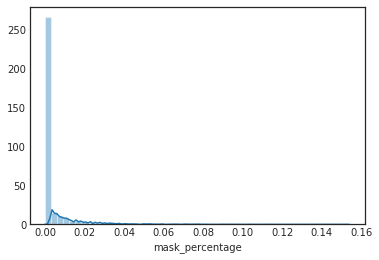

In [4]:
all_mask_fn = glob.glob('/kaggle/input/siimacr-pneumothorax-segmentation-data-256/masks/*')
mask_df = pd.DataFrame()
mask_df['file_names'] = all_mask_fn
mask_df['mask_percentage'] = 0
mask_df.set_index('file_names',inplace=True)
for fn in all_mask_fn:
    mask_df.loc[fn,'mask_percentage'] = np.array(Image.open(fn)).sum()/(256*256*255) #255 is bcz img range is 255
    
mask_df.reset_index(inplace=True)
sns.distplot(mask_df.mask_percentage)
mask_df['labels'] = 0
mask_df.loc[mask_df.mask_percentage>0,'labels'] = 1

In [5]:
mask_df.to_csv('data.csv',index = False)

In [6]:
id_label_map = {i : j for i,j in zip(mask_df.file_names.values,mask_df.labels.values)}

In [7]:
train_df,val_df = train_test_split(mask_df,test_size = 0.15,stratify = mask_df.labels,random_state = 100)

In [8]:
print('No. of train files:', len(train_df))
print('No. of val files:', len(val_df))

No. of train files: 10239
No. of val files: 1808


In [9]:
train_filepath = train_df['file_names'].tolist()
val_filepath = val_df['file_names'].tolist()
train_im_path = 'train'
train_mask_path = 'masks'
img_size = 256

In [10]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)
train_augment = Compose([
    HorizontalFlip(p = 0.5),
    ShiftScaleRotate(p = 0.5),
    #ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03,p = 0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.3),
    OneOf([
        RandomSizedCrop(min_max_height=(176, 256), height=256, width=256,p=0.25),
        CLAHE(clip_limit=2.0, tile_grid_size=(32,32),p = 0.4),
         ], p=0.5),
    ToFloat()
])

In [11]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self,filepath = train_filepath,train_im_path = train_im_path,train_mask_path = train_mask_path,
                 augmentations = None,img_size = img_size,batch_size = 64,nchannels = 3,shuffle = True):
        
        self.train_im_paths = list(filepath)
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path
        self.img_size = img_size
        self.batch_size = batch_size
        self.nchannels = nchannels
        self.shuffle = shuffle
        self.augmentations = augmentations
        self.on_epoch_end()
    
    def __len__(self):
        
        return int(np.ceil(len(self.train_im_paths)/ self.batch_size))
    
    def __getitem__(self,index):
        
        indexes = self.indexes[index * self.batch_size : min((index + 1) * self.batch_size, len(self.train_im_paths))]
        list_im_ids = [self.train_im_paths[i] for i in indexes]
        X,y = self.data_generation(list_im_ids)
        
        if(self.augmentations is None):
            return np.array(X,dtype = 'float32'),np.array(y) / 255
        
        im,mask = [],[]
        for x,y in zip(X,y):
            augmented = self.augmentations(image = x,mask = y)
            im.append(augmented['image'])
            mask.append(augmented['mask'])
        return np.array(im,dtype = 'float32'),np.array(mask) / 255
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.train_im_paths))
        if(self.shuffle):
            np.random.shuffle(self.indexes)
    
    def data_generation(self,list_im_ids):
        
        X = np.empty((len(list_im_ids),self.img_size,self.img_size,self.nchannels))
        y = np.empty((len(list_im_ids),self.img_size,self.img_size,1))
        for i,mask_path in enumerate(list_im_ids):
            #print(mask_path)
            mask = np.array(Image.open(mask_path))
            #plt.imshow(mask)
            img_path = mask_path.replace(self.train_mask_path,self.train_im_path)
            img = cv2.imread(img_path)
#             lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

#             lab_planes = cv2.split(lab)

#             clahe = cv2.createCLAHE(clipLimit=3.0,tileGridSize=(32,32))

#             lab_planes[0] = clahe.apply(lab_planes[0])

#             lab = cv2.merge(lab_planes)

#             img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
#             img = np.true_divide(img,255.)
            #plt.imshow(img,cmap = 'bone')
            if(len(img.shape) == 2):
                img = np.repeat(img[...,np.newaxis],3,2)
            
           # plt.imshow(img,cmap = 'bone')
            X[i,] = cv2.resize(img,(self.img_size,self.img_size))
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[...,np.newaxis]
            y[y > 0] = 255
        return np.uint8(X),np.uint8(y)

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

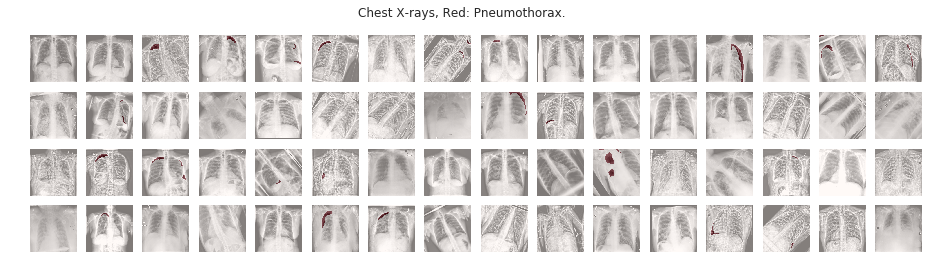

In [12]:
a = DataGenerator(batch_size=64,shuffle=False,augmentations=train_augment)
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

In [13]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [14]:
def UNet(image_size):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [15]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [16]:
# backbone = Xception(input_shape=(512,512,3),weights='imagenet',include_top=False)
# input = backbone.input

In [17]:
def UXception(input_shape=(None, None, 3),dropout_rate=0.5):

    backbone = Xception(input_shape=input_shape,weights='imagenet',include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(dropout_rate)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [18]:
# #img_size = 256
# model = UXception(input_shape=(img_size,img_size,3))
# model.summary()

In [19]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [20]:
model = sm.Unet('seresnet34', input_shape=(img_size,img_size,3), encoder_weights='imagenet',decoder_block_type='transpose')

86319104/86315168 [==============================] - 2s 0us/step


In [21]:
#model.summary()

In [22]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')


In [23]:
class SnapshotCallbackBuilder:
    """Callback builder for snapshot ensemble training of a model.
    From the paper "Snapshot Ensembles: Train 1, Get M For Free" (
    https://openreview.net/pdf?id=BJYwwY9ll)
    Creates a list of callbacks, which are provided when training a model
    so as to save the model weights at certain epochs, and then sharply
    increase the learning rate.
    """

    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.01):
        """
        Initialize a snapshot callback builder.
        # Arguments:
            nb_epochs: total number of epochs that the model will be trained for.
            nb_snapshots: number of times the weights of the model will be saved.
            init_lr: initial learning rate
        """
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./keras.model",monitor='val_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)



In [24]:
def get_iou_vector(A,B):
    batch_size = A.shape[0]
    metric = 0.0
    for i in range(batch_size):
        t,p = A[i],B[i]
        #print(t.dtype)
        p = tf.dtypes.cast(p, tf.float32)
        intersection = np.sum(t * p)
        true = np.sum(t)
        pred = np.sum(p)
        
        if(true == 0):
            metric += (pred == 0)
            
        union = true + pred - intersection
        iou = intersection / union
        iou = np.floor(max(0,(iou - 0.45) * 20)) / 10
        metric += iou
    return metric / batch_size
def iou_metric(label,pred):
    return tf.py_function(get_iou_vector,[label,pred > 0.5],tf.float64)

In [25]:
def dice_coeff(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.cast(K.greater(K.flatten(y_pred),0.5),'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    dice_coeff = (intersection * 2) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return dice_coeff
def dice_loss(y_true,y_pred):   
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_coeff = (intersection * 2 + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - dice_coeff
def bce_dice_loss(y_true,y_pred):
    return binary_crossentropy(y_true,y_pred) + dice_loss(y_true,y_pred)
def bce_logdice_loss(y_true,y_pred):
    return binary_crossentropy(y_true,y_pred) - K.log(1. - dice_loss(y_true,y_pred))

In [26]:
#model.compile(loss = sm.losses.bce_jaccard_loss,optimizer = SGD(learning_rate = 0.0001, momentum=0.0, nesterov=False),metrics = [sm.metrics.iou_score])
model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[iou_metric])

In [27]:
train_filepath = train_df['file_names'].tolist()
val_filepath = val_df['file_names'].tolist()
train_im_path = 'train'
train_mask_path = 'masks'
epochs = 110
snapshot = SnapshotCallbackBuilder(nb_epochs = epochs,nb_snapshots = 1, init_lr = 1e-3)
swa = SWA('./keras_swa.model',106)
batch_size = 64
train_generator = DataGenerator(filepath = train_filepath, augmentations=train_augment, batch_size = batch_size)
val_generator = DataGenerator(filepath = val_filepath, augmentations=train_augment, batch_size = batch_size)
history = model.fit_generator(train_generator,validation_data = val_generator,epochs = epochs,callbacks = snapshot.get_callbacks())

Stochastic weight averaging selected for last 4 epochs.
Epoch 1/110


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater


  9/160 [>.............................] - ETA: 15:38 - loss: 1.4927 - iou_metric: 0.0017    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in float_scalars
  app.launch_new_instance()


160/160 [==============================] - 302s 2s/step - loss: 1.0625 - iou_metric: 0.5536 - val_loss: 998.7352 - val_iou_metric: 0.0000e+00

Epoch 00001: val_iou_metric improved from -inf to 0.00000, saving model to ./keras.model
Epoch 2/110
160/160 [==============================] - 252s 2s/step - loss: 0.9031 - iou_metric: 0.4462 - val_loss: 1.0212 - val_iou_metric: 0.7791

Epoch 00002: val_iou_metric improved from 0.00000 to 0.77909, saving model to ./keras.model
Epoch 3/110
160/160 [==============================] - 252s 2s/step - loss: 0.8554 - iou_metric: 0.5139 - val_loss: 1.0227 - val_iou_metric: 0.7802

Epoch 00003: val_iou_metric improved from 0.77909 to 0.78017, saving model to ./keras.model
Epoch 4/110
160/160 [==============================] - 255s 2s/step - loss: 0.8262 - iou_metric: 0.5771 - val_loss: 1.0042 - val_iou_metric: 0.7807

Epoch 00004: val_iou_metric improved from 0.78017 to 0.78071, saving model to ./keras.model
Epoch 5/110
160/160 [========================

176

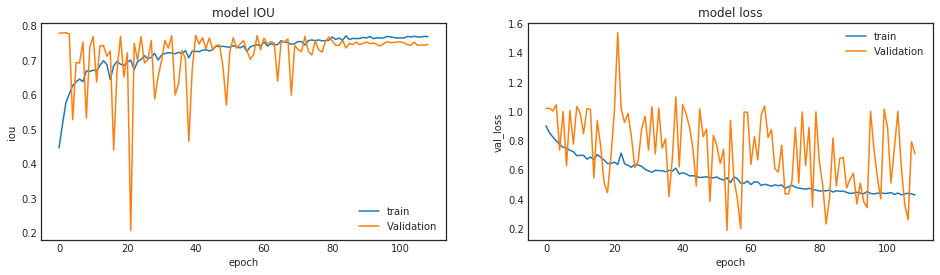

In [28]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['iou_metric'][1:])
plt.plot(history.history['val_iou_metric'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='lower right')

plt.title('model IOU')
plt.savefig('iou.png')

plt.subplot(1,2,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper right')
plt.title('model loss')
plt.savefig('loss.png')
gc.collect()

In [29]:
try:
    print('using swa weight model')
    model.load_weights('./keras_swa.model')
except Exception as e:
    print(e)
    model.load_weights('./keras.model')

using swa weight model


In [30]:
def predict_result(model,validation_generator,img_size): 
    # TBD predict both orginal and reflect x
    preds_test1 = model.predict_generator(validation_generator).reshape(-1, img_size, img_size)
    return preds_test1

In [31]:
val_augment_flipped = Compose([
    HorizontalFlip(),
    ToFloat()
])
val_augment = Compose([
    ToFloat()
])
validation_generator = DataGenerator(filepath = val_filepath, augmentations=val_augment, batch_size = batch_size, shuffle = False)
validation_generator_flipped = DataGenerator(filepath = val_filepath, augmentations=val_augment_flipped, batch_size = batch_size,  shuffle = False)
val_preds_flipped = predict_result(model,validation_generator_flipped, img_size)
val_preds = predict_result(model,validation_generator, img_size)
val_preds = 0.5 * val_preds_flipped + 0.5 * val_preds

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater


Text(0.5, 0.98, 'Green:Prediction , Red: Pneumothorax.')

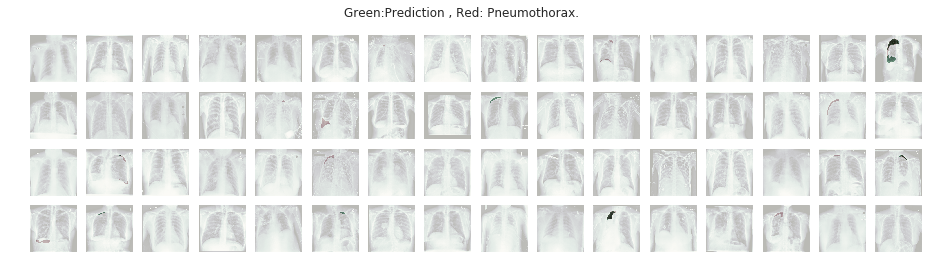

In [32]:
threshold_best = 0.5
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

validation_generator = DataGenerator(filepath = val_filepath, augmentations=val_augment, batch_size = 64, shuffle = False)

images,masks = validation_generator.__getitem__(0)
for i,(im, mask) in enumerate(zip(images,masks)):
    pred = val_preds[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green:Prediction , Red: Pneumothorax.")

In [33]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

#valid_fn = glob.glob('./keras_mask_val/*')
y_valid_ori = np.array([cv2.resize(np.array(Image.open(fn)),(img_size,img_size)) for fn in val_filepath])
assert y_valid_ori.shape == val_preds.shape

In [34]:
thresholds = np.linspace(0.2, 0.9, 31)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(val_preds > threshold)) for threshold in tqdm_notebook(thresholds)])

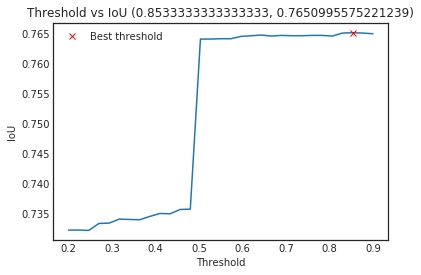

In [35]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater


Text(0.5, 0.98, 'Green:Prediction , Red: Pneumothorax.')

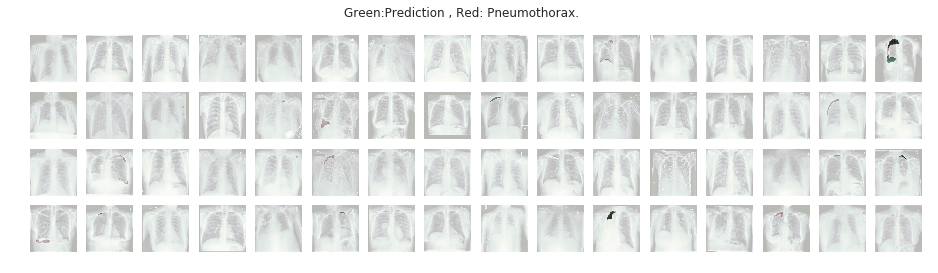

In [36]:
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

# validation_generator = DataGenerator(train_im_path = valid_im_path ,
#                                      train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
#                                      img_size=img_size,batch_size=64,shuffle=False)
validation_generator = DataGenerator(filepath = val_filepath, augmentations=val_augment, batch_size = 64, shuffle = False)

images,masks = validation_generator.__getitem__(0)
for i,(im, mask) in enumerate(zip(images,masks)):
    pred = val_preds[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green:Prediction , Red: Pneumothorax.")

In [37]:
test_fn = glob.glob('/kaggle/input/siimacr-pneumothorax-segmentation-data-256/test/*')
x_test = [cv2.resize(np.array(Image.open(fn)),(img_size,img_size)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
print(x_test.shape)
preds_test_orig = model.predict(x_test,batch_size=batch_size)

x_test = np.array([np.fliplr(x) for x in x_test])
preds_test_flipped = model.predict(x_test,batch_size=batch_size)
preds_test_flipped = np.array([np.fliplr(x) for x in preds_test_flipped])

preds_test = 0.5*preds_test_orig + 0.5*preds_test_flipped

(3205, 256, 256, 3)


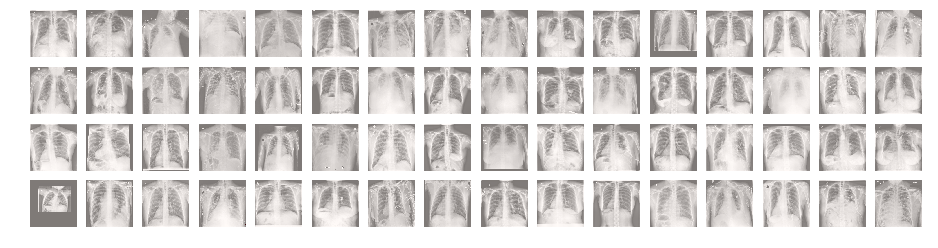

In [38]:
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
# for i, idx in enumerate(index_val[:max_images]):
for i, idx in enumerate(test_fn[:max_images]):
    img = x_test[i]
    pred = preds_test[i].squeeze()
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(np.array(np.round(pred > threshold_best).T, dtype=np.float32), alpha=0.5, cmap="Reds")
    ax.axis('off')

In [39]:
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

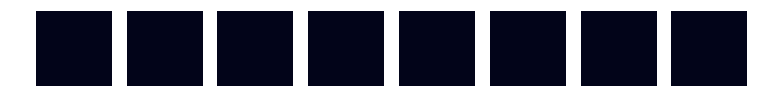

In [40]:
import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')

#from mask_functions import rle2mask,mask2rle
import pdb

# Generate rle encodings (images are first converted to the original size)
rles = []
i,max_img = 1,10
plt.figure(figsize=(16,4))
for p in tqdm_notebook(preds_test):
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    im = im > threshold_best
#     zero out the smaller regions.
    if im.sum()<1024*2:
        im[:] = 0
    im = (im.T*255).astype(np.uint8)  
    rles.append(mask2rle(im, 1024, 1024))
    i += 1
    if i<max_img:
        plt.subplot(1,max_img,i)
        plt.imshow(im)
        plt.axis('off')

In [41]:
ids = [o.split('/')[-1][:-4] for o in test_fn]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

,ImageId,EncodedPixels
0,ID_fdfafd5af,-1
1,ID_6f6a45624,-1
2,ID_298e11c39,-1
3,ID_438a1bc12,-1
4,ID_8b2c18ac1,-1


In [42]:
!pip install kaggle

     |████████████████████████████████| 61kB 2.3MB/s 
     |████████████████████████████████| 81kB 5.5MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=8cbaa37081fbe3656007a47a23fd66f9c6baad18cd430e6e64106c21433c7adc
  Stored in directory: /tmp/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
  Created wheel for python-slugify: filename=python_slugify-4.0.0-py2.py3-none-any.whl size=5487 sha256=771e8216655fdec207e33c1576e8cff03e6901e7aa18cdee39cbe7eb9f4a1b8d
  Stored in directory: /tmp/.cache/pip/wheels/11/94/81/312969455540cb0e6a773e5d68a73c14128bfdfd4a7969bb4f
Successfully built kaggle python-slugify


In [43]:
os.environ['KAGGLE_USERNAME'] = "aaryapatel98"
os.environ['KAGGLE_KEY'] = "75398e02b13a492c8a28ed09e05930e7"

In [44]:
sub_df.to_csv('submission.csv', index=False)

In [45]:
!kaggle competitions submit siim-acr-pneumothorax-segmentation -f submission.csv -m "My submission message"

100%|██████████████████████████████████████| 50.3k/50.3k [00:01<00:00, 41.7kB/s]
Successfully submitted to SIIM-ACR Pneumothorax Segmentation